
# Local Linear Embedding


### This section covers the Local Linear Embedding (LLE) Algorithm

Local linear embedding is an algorithm for non-linear dimensionality reduction. Unlike Multidimensional Scaling, LLE is capable of learning non-linear manifold approximations for higher dimensional datasets. <br>
<br>
The idea behind LLE is that we define data points in terms of their local linear relationships. We define data point $X_i$ as a linear combination of its local neighbors, and then we find a lower dimensional embedding that preserves these local linear relationships. <br>
<br>
LLE is an intuitive approach based on the idea that small enough neighborhoods will represent patches lying along the manifold, which will then be approximately linear. By fitting locally along the manifold and finding a global coordinate system for the lower dimensional embedding, LLE can learn global, non-linear manifold geometries.

![lle](https://user-images.githubusercontent.com/16658498/56095416-5c6ef800-5ea2-11e9-8ce0-5da013aee4e8.gif)


## The Algorithm

**Algorithm Outline**: <br>
<br>
The Locally Linear Embedding algorithm has only one parameter k = number of nearest neighbors to consider, and then requires solving two optimization problems: <br>
<br>
Input - X , matrix with N observations in D dimensions <br>
Output - Y, matrix with N observations in d << D dimensions <br>
Parameter(s) = k, number of nearest neighbors to consider <br>
1. Find k nearest neighbors for each $X_i$ in X <br>
2. Solve for weights W to write each $X_i$ as linear combination of neighbors <br>
3. Compute lower dimensional embedding coordinates $Y_i$ that preserve local, linear relationships


## Step 1: Find k nearest neighbors

First, the parameter k must be defined to specify the number of nearest neighbors we use to linearly model $X_i$. There's no guaranteed way to know the optimal value of k before applying the algorithm, and different values of k along with different ways of defining the distance metric affect the performance of LLE. <br>
<br>
Here we show the effect of different values of k on LLE performed on a deformed sphere in 3D. We use the standard Euclidean distance metric from here on.

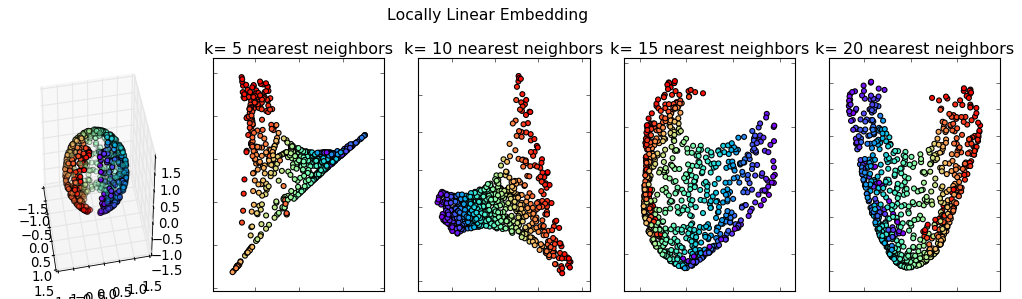

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

plt.style.use('classic')
plt.rcParams['figure.figsize'] = (6.5, 6.5)
plt.rcParams['figure.facecolor'] = 'white'

n_samples = 1000

# Create our sphere
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# Plot our dataset
fig = plt.figure(figsize=(16, 8))
plt.suptitle("Locally Linear Embedding", fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# Perform Locally Linear Embedding 
neighbors = np.arange(5, 25, 5)

for i, neighbor in enumerate(neighbors):
    trans_data = manifold.LocallyLinearEmbedding(neighbor, 2).fit_transform(sphere_data).T
    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow);
    ax.xaxis.set_major_formatter(NullFormatter());
    ax.yaxis.set_major_formatter(NullFormatter());
    plt.title('k= ' +str(neighbor) + ' nearest neighbors')
    plt.axis('tight');
plt.show();


## Step 2: Linearly weighted combination of k-NN

**Step 2**: Define each data point $X_i$ in terms of its local linear relationships. <br>  
We have to define a parameter k to specify the number of nearest neighbors we consider. Then, for each $X_i$ in dimension D, we reconstruct $X_i$ using a linear combination of its k nearest neighbors. <br>
<br>
**Note**: this linear combination reconstruction is also in dimension D.  

For each point $X_i$ we define a linear combination with the weight matrix $W$ and its nearest neighbors $X_j$. <br> We have the total reconstruction error defined by cost function: 

$$\mathcal{E}(W) = \sum_{i} ||X_i - \sum_{j} W_{ij} X_j||^2$$

This has a residual sum of squares form where we have the error as the Euclidean distance between the original $X_i$ and our nearest neighbors construction

For our weight matrix W, we have

$$\mathbf{W} = \begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n} \\
w_{21} & w_{22} & \cdots & w_{2n} \\
\vdots & \vdots & \vdots & \vdots \\
w_{n1} & w_{n2} & \cdots & w_{nn}
\end{bmatrix}$$ <br>
<br>
where for some $X_i$ we have the linear combination $\sum_{j} W_{ij} X_j = w_{i1} X_{1} + \cdots + w_{in} X_{n}$ 

Now we show an example illustrating the reconstruction by linear weights of local neighbors.


### Ex.) Locally Linear Neighborhoods and Connection to PCA

Using the 'S' curve from before, we have the following 3D dataset.

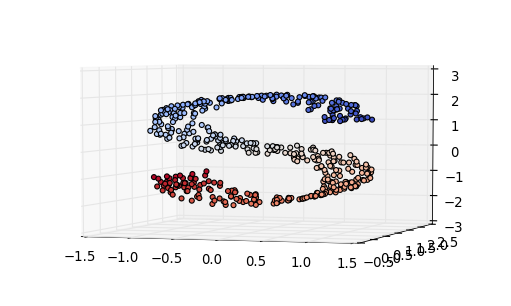

In [101]:
from sklearn.datasets.samples_generator import make_s_curve
data, color = make_s_curve(500, random_state=0)
fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, alpha=1, cmap=plt.cm.coolwarm)
ax.view_init(4, -72);

From the example above, we have a dataset that we take to be an embedded 2D manifold in this higher dimensional 3D space. We consider a local neighborhood and visualize how we can use linear combinations to represent the intrinsic geometry.

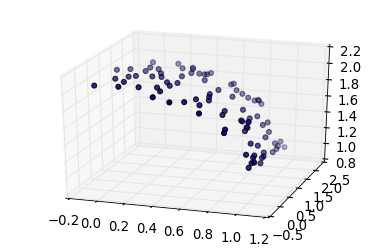

In [102]:
fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(211, projection='3d')
neighborhood1 = data[color < -3]
ax.scatter(neighborhood1[:, 0], neighborhood1[:, 1], neighborhood1[:, 2], c='darkblue')
ax.view_init(24, -72);

In this neighborhood the data can be reasonably approximately as lying close to a 2D plane. The plane that minimizes the information lost in this projection can be found by using Principal Component Analysis for this local neighborhood.

In [103]:
from sklearn.decomposition import PCA

# center around the mean
X_centered = neighborhood1 - neighborhood1.mean(axis=0)
X = X_centered

# project onto first two principal axes with sklearn
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

In [104]:
# equations to define the plane
axes = [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

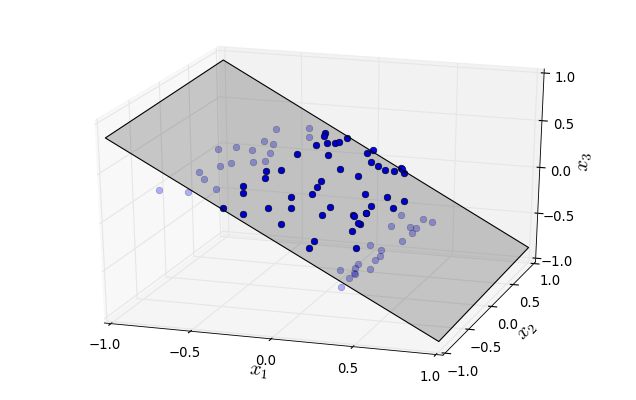

In [105]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.3)
ax.plot_surface(x1, x2, z, alpha=0.2, color="black")   
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")

ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
ax.view_init(24, -72);
plt.show();

Consider a different local neighborhood of the 'S' curve, denoted in red. We describe the local, linear relationships of this neighborhood in the same way.

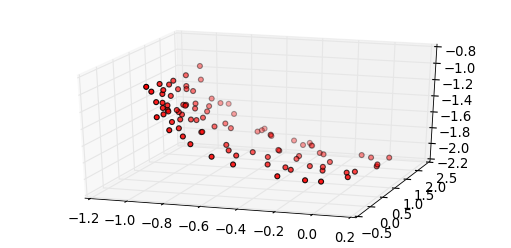

In [106]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(211, projection='3d')
neighborhood2 = data[color > 3]
ax.scatter(neighborhood2[:, 0], neighborhood2[:, 1], neighborhood2[:, 2], c='red')
ax.view_init(24, -72);

In this neighborhood the data can be reasonably approximately as lying close to a 2D plane.

In [107]:
# center around the mean
X_centered = neighborhood2 - neighborhood2.mean(axis=0)
X = X_centered

# first two principal components
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

In [108]:
# equations to define the plane
axes = [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

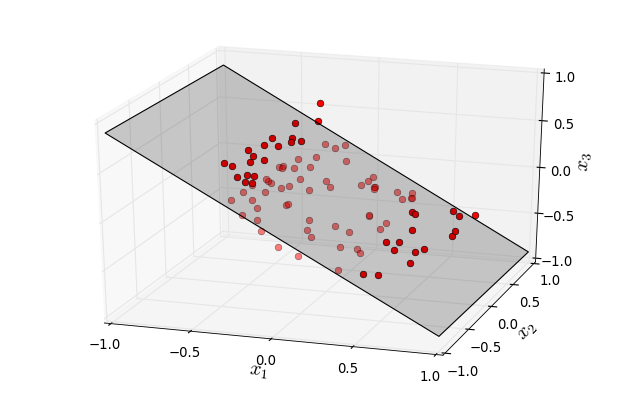

In [109]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.5)
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
ax.view_init(24, -72);
plt.show();

Continuing on in this way, we can see that Local Linear Embedding is very similar to a collection of local principal component projections that globally combine to define a non-linear embedding. We imagine locally linear patches in the manifold, and although the data is globally non-linear, we "learn" these locally linear representations of the data.

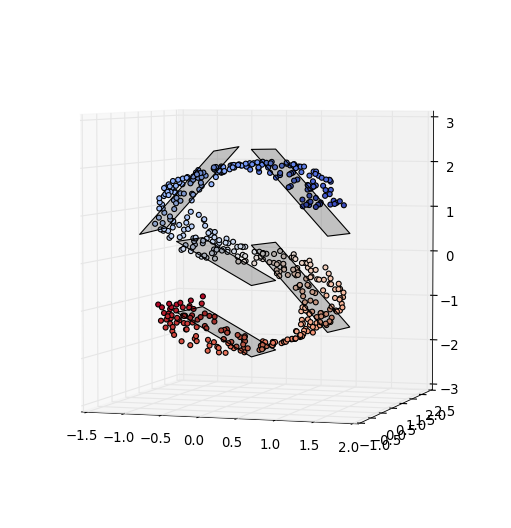

In [110]:
# plot example local patches
fig = plt.figure(frameon=False, figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, alpha=1, cmap=plt.cm.coolwarm)
ax.plot_surface(x1 / 2, x2 / 2, z / 2, alpha=0.2, color="k")
ax.plot_surface(x1 / 2, x2 / 2, z / 2 - 1.5, alpha=0.2, color="k")
ax.plot_surface((x1 + 2) / 2, x2 / 2, z-0.5, alpha=0.2, color="k")
ax.plot_surface((x1 - 1) / 2, x2 / 2, - z + 1.5, alpha=0.2, color="k")
ax.plot_surface((x1 + 2) / 2, x2 / 2, z + 1.5, alpha=0.2, color="k")
ax.view_init(4, -72);


### Invariance to rotation, scaling, translation

By the way we defined the cost function, the optimal weights are invariant to rotation, scaling, and translation, so they reflect intrinsic geometric properties of the original data space. <br>
<br>
There exists an approximately linear mapping (translation, rotation, and rescaling) that maps $X_i$ to the lower dimensional manifold. Therefore, since the weights are invariant, these same optimal weights that reconstruct $X_i$ in D dimensions (as described above), also reconstruct the embedded manifold coordinates of $X_i$ in d dimensions.


### Constrained Optimization : Finding Weights with Constrained Least Squares

**Constrined Least Squares Problem** <br>
<br>
Find weights that minimize $$\mathcal{E}(W) = \sum_{i} ||X_i - \sum_{j} W_{ij} X_j||^2$$
subject to the constraints: <br>
- $W_{ij} = 0$ if $X_{j}$ not one of the nearest neighbors for a given $X_i$ (we only consider the local neighborhood) <br>
- The rows of the weight matrix sum to one: $\sum_{j} W_{ij} = 1$

Consider error for a particular $X_i$:  $$\mathcal{E}_i = ||X_i - \sum_{j} W_{ij} X_j||^2$$
and since sum of weights = 1, we have $$\mathcal{E}_i = ||\sum_{j} W_{ij}X_i - \sum_{j} W_{ij} X_j||^2$$
after factoring: $$\mathcal{E}_i = ||\sum_{j} W_{ij} (X_i - X_j)||^2$$

Since this quantity is squared we can swap the order of $X_i$ and $X_j$ <br>: $$\mathcal{E}_i = ||\sum_{j} W_{ij} (X_j - X_i)||^2$$

Let $z_j = x_j - x_i$, and with k neighbors $\mathbf{z}$ is the k x p matrix with rows <br>
<br>
$$\mathbf{z} = \begin{bmatrix}
z_{1} = x_{1} - x_{i} \\
z_{2} = x_{2} - x_{i} \\
\vdots & \\
z_{k} = x_{k} - x_{i} 
\end{bmatrix}$$

and $w_i$ is the k x 1 matrix with weights for each neighbor of $x_i$. <br>
<br>
$$\mathbf{w_i} = \begin{bmatrix}
w_{i1} \\
w_{i2} \\
\vdots & \\
w_{ik}  
\end{bmatrix}$$

Therefore <br>

\begin{equation}
\begin{aligned}
\mathcal{E}_i & = ||\sum_{j} W_{ij} (X_j - X_i)||^2\\
\\
            & = ||\sum_{j} W_{ij} Z_j||^2\\
\\
            & = ||w_{i1} z_1 + ... + w_{ik} z_k||^2\\
\\
            & = ||w_{i}^{T} z||^2\\
\\
            & = w_{i}^{T} z (w_{i}^{T} z)^{T}\\
\\
            & = w_{i}^{T} z z^{T} w_{i}\\
\end{aligned}
\end{equation}

**Note**: the second to last line follows from $||\mathbf{r}||^2 = \mathbf{r} \mathbf{r}^T$ for a 1 x p row vector $\mathbf{r}$ and $w_{i}^{T} z$ is a 1 x p row vector.

$zz^{T}$ is the **Gram matrix** centered at $x_i$, which we denote $G_i$. The Gram matrix is symmetric, positive semi-definite k x k matrix containing inner products of pairwise differences for local neighborhood of $x_i$ <br>
<br>
For $X_i$ with nearest neighbors $X_1, ..., X_k$: $$G_{jk} = \langle\ X_i - X_j, X_i - X_k \rangle$$ 

**Lagrange Multiplier Problem**

We set up langrange multiplier problem with $\mathbf{1}^T$ as the k x 1 matrix of all 1's so <br> $$\mathbf{1}^T w = \mathbf{1}$$ represents our constraint that the weights sum to 1.

$$\mathcal{L}(w_i, \lambda) = w_{i}^{T} G_i w_{i} - \lambda(\mathbf{1}^T w - \mathbf{1}) = 0$$

\begin{equation}
\frac{\partial \mathcal{L}}{\partial w_i} = 2G_i w_i - \lambda \mathbf{1} = 0 \\
\\
\frac{\partial \mathcal{L}}{\partial \lambda} = \mathbf{1}^T w_i - \mathbf{1} = 0
\end{equation}

From the first partial derivative: <br>
$$2G_i w_i = \lambda \mathbf{1} $$

And if Gram matrix G is invertible, we have a closed form to compute the optimal weights: <br>
$$\boxed {w_i = \frac{\lambda}{2} G_{i}^{-1} \mathbf{1}}$$ <br>
where $\lambda$ can be chosen to ensure everything sums to 1.

**Note:** We find the optimal weights for each point separately

**Note:** G represents a local covariance matrix of distances and we index over all pairs of points in the local neighborhood with $X_j \ , X_k$ as local neighbors and <br>
$$G_{jk} = \langle\ X_i - X_j, X_i - X_k \rangle$$

Covariance is invariant to linear transformations and this illustrates why the optimal weights remain constant under rescaling, rotation, and translation. <br>
$$Cov(X_i, X_j) = \frac{\sum (X_i - \mu_i) (X_j - \mu_j)}{n}$$ <br>
**Note:** If problem ill-conditioned (k > D), can add by small multiple of identity matrix


## Step 3: Map to lower dimensional space

**Step 3**: Construct the mapping from each $X_i$ in D to its lower dimensional manifold representation $Y_i$ in d. <br>  
Since the optimal weights we found have certain invariant properties, we use these weights in this mapping. We define a new cost function with a similar form to the previous one, where we want to minimize reconstruction error:

$$\phi(Y) = \sum_{i} ||Y_i - \sum_{j} (W_{ij} Y_j)||^2$$
This time, we fix the weights and find optimal coordinates $Y_i$ <br>


### Eigenvalue Problem: Optimal Embedding Coordinates

We seek $Y_i$ in dimension d that minimize the embedding cost function: <br> 
<br>
$$\phi(Y) = \sum_{i} ||Y_i - \sum_{j} (W_{ij} Y_j)||^2$$<br>
where $W_{ij}$ are fixed and we have constraints on the output coordinates: 
- $\sum_i Y_i = 0$ (centered on the origin, translational degree of freedom)<br>
- $\frac{1}{N} \sum_i Y_i Y_i^T = \mathbf{I}$ (unit covariance, rotational degree of freedom) <br>

We have constraint of unit covariance and that the mean is zero. We consider dimension 1 where $y_i \in \mathbb{R}$ and arrive at a similar solution for the general case.
$$
\begin{aligned} \Phi(\mathbf{Y}) &=\sum_{i=1}^{n}\left(y_{i}-\sum_{j} w_{i j} y_{j}\right)^{2} \\ &=\sum_{i=1}^{n} y_{i}^{2}-y_{i}\left(\sum_{j} w_{i j} y_{j}\right)-\left(\sum_{j} w_{i j} y_{j}\right) y_{i}+\left(\sum_{j} w_{i j} y_{j}\right)^{2} \\ &=\mathbf{Y}^{T} \mathbf{Y}-\mathbf{Y}^{T}(\mathbf{w} \mathbf{Y})-(\mathbf{w} \mathbf{Y})^{T} \mathbf{Y}+(\mathbf{w} \mathbf{Y})^{T}(\mathbf{w} \mathbf{Y}) \\ &=((\mathbf{I}-\mathbf{w}) \mathbf{Y})^{T}((\mathbf{I}-\mathbf{w}) \mathbf{Y}) \\ &=\mathbf{Y}^{T}(\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \mathbf{Y} \end{aligned}
$$

Define the m x m matrix $M$:
$$
\begin{aligned} \mathbf{M} &= (\mathbf{I}-\mathbf{w})^{T}(\mathbf{I}-\mathbf{w}) \end{aligned}
$$

and so $$\Phi(\mathbf{Y})=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}$$

We set up a Lagrange multiplier $\mu$ to impose the constraint $n^{-1} \mathbf{Y}^{T} \mathbf{Y} = \mathbf{I}$ <br>
<br>
$$
\mathcal{L}(\mathbf{Y}, \mu)=\mathbf{Y}^{T} \mathbf{M} \mathbf{Y}-\mu\left(n^{-1} \mathbf{Y}^{T} \mathbf{Y}-1\right)
$$

$$
\begin{array}{c}{\frac{\partial \mathcal{L}}{\partial \mathbf{Y}}=2 \mathbf{M} \mathbf{Y}-2 \mu n^{-1} \mathbf{Y}=0} \\ {\mathbf{M Y}=\frac{\mu}{n} \mathbf{Y}}\end{array}
$$

By the last line, $Y$ is an eigenvector of $M$ and so to minimize 

$$\phi(Y) = Y^{T} M Y$$ <br>
we choose the bottom d+1 eigenvectors (smallest eigenvalues) of M as our coordinates on the manifold.


## LLE with scikit-learn

We apply LLE to some synthetic datasets for manifold learning to see how the LLE algorithm can learn complex non-linear structures.

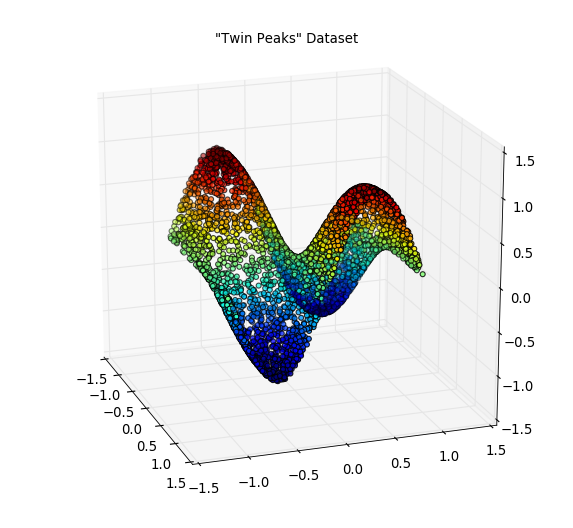

In [116]:
# twin peaks dataset
n = 5000
param = 1
xy = 1 - 2 * np.random.rand(2, n)
p = np.array([xy[1, :], xy[0, :], param * np.sin(np.pi * xy[0, :]) * np.tanh(3 * xy[1, :])]).T
color = p[:, 2]
fig = plt.figure(figsize = (9, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], c=color, cmap=plt.cm.jet)
plt.title('"Twin Peaks" Dataset', size=12)
ax.view_init(20, -19);

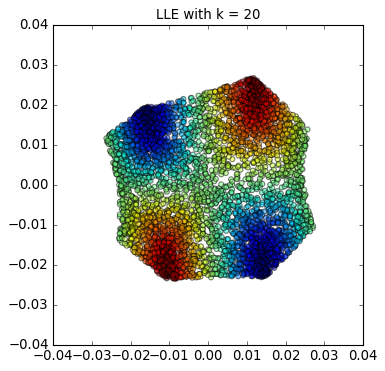

In [117]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=20) 
X_reduced = lle.fit_transform(p)
fig = plt.figure(figsize = (5, 5))
plt.title('LLE with k = 20', size=12)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, cmap=plt.cm.jet, alpha=0.5);

LLE performs fairly well on this highly non-linear dataset. In general the 2-dimensional embedding keeps close instances in $\mathbb{R^3}$ close together and further instances further apart. <br>
<br>
We now look at another interesting case where a large density of samples is clustered at the boundary. 

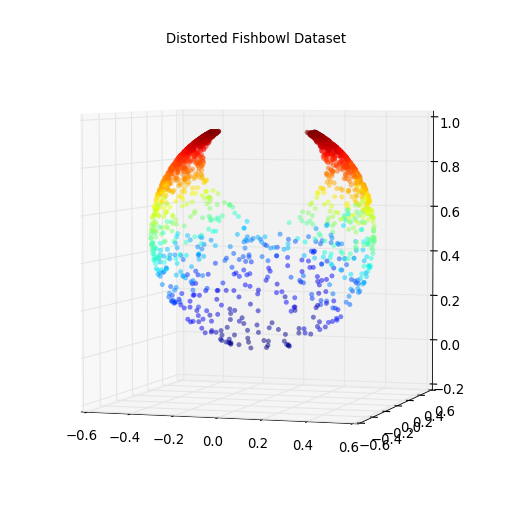

In [118]:
from numpy import random
data = random.uniform(-1, 1, (2000,2))
s = 4*data[:,0]
t = data[:,1]

x = s / (1 + s**2 + t**2)
y = t / (1 + s**2 + t**2)
z = (s**2 + t**2) / (1 + s**2 + t**2)
color = (x**2 + z**2) / 0.3

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")

# fishbowl dataset
ax.scatter(x, y, z, c=color, cmap=plt.cm.jet, lw=0, alpha=0.5);
plt.title('Distorted Fishbowl Dataset', size=12)
ax.view_init(4, -72);

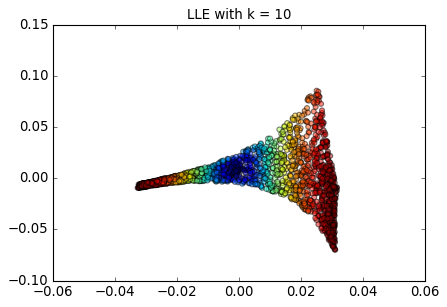

In [119]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=10)
X = np.hstack((x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)))
X_reduced = lle.fit_transform(X)
fig = plt.figure(figsize = (6, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, cmap=plt.cm.jet, alpha=0.5)
plt.title('LLE with k = 10', size=12);

Local linear embedding is able to uncover the manifold structure in this dataset as well. It's not necessarily surprising that LLE can learn such non-linear intrinsic structures, but it's interesting to think what other problems can arise like this non-uniformity of the samples or clustering near the boundary. <br>
<br>
We consider one of these problems in the following dataset that has holes in the manifold structure. 

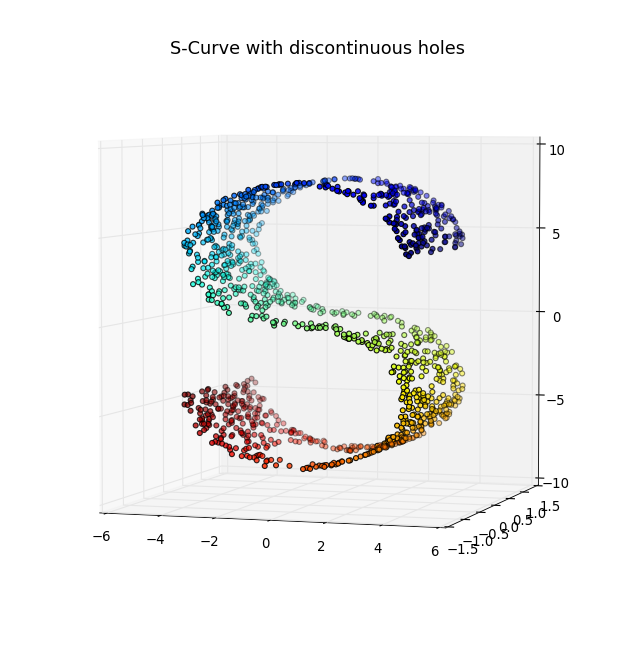

In [120]:
from sklearn.datasets.samples_generator import make_s_curve
data, color = make_s_curve(1500, random_state=0)
x = data[:, 0]*4 
y = data[:, 1] - 1
z = data[:, 2]*4

# applying a filter to create a hole in our S curve
z2 = z[(abs(x) >= 2) | (abs(y) >= 0.5)]
y2 = y[(abs(x) >= 2) | (abs(y) >= 0.5)]
x2 = x[(abs(x) >= 2) | (abs(y) >= 0.5)]
color = color[(abs(x) >= 2) | (abs(y) >= 0.5)]

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x2, y2, z2, c=color, cmap=plt.cm.jet)
plt.title('S-Curve with discontinuous holes', size=16)
ax.view_init(4, -72);

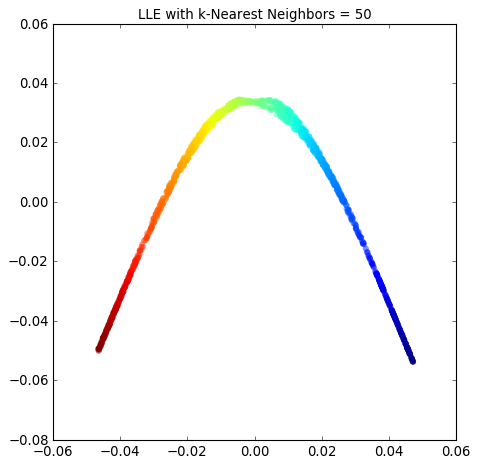

In [122]:
data = np.hstack((x2.reshape(-1,1),y2.reshape(-1,1),z2.reshape(-1,1)))

k = 50

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=k)
proj = lle.fit_transform(data)

plt.scatter(proj[:, 0], proj[:, 1], c=color, cmap=plt.cm.jet, s=30, lw=0, alpha=0.5)
plt.title('LLE with k-Nearest Neighbors = ' + str(k), size=12)
plt.show();

In this case, LLE is unable to uncover the manifold representation, but this makes sense when considering that the nearest neighbor search and the local linear reconstructions could very easily fail with these discontinuities. In a sense, many discontinuities or holes in the data implies that our manifold hypothesis might not be valid. <br>
<br>
These challenges posed to nonlinear dimensionality reduction and manifold learning are also an interesting means to compare how the different algorithms are able to handle them. This will be an important way to learn how these approaches work and what challenges continue to drive research in the field.  

---
## References
[1] S. T. Roweis and L. K. Saul. *Nonlinear dimensionality reduction by locally linear
embedding*. Science 290, 2323-2326 (2000). <br>